In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [8]:
num_classes = 10 # the total number of classes, in our case these are numbers from 0 to 9
num_features = 784 # number of attributes of the input vector 28 * 28 = 784

learning_rate = 0.001 # learning rate of the neural network
training_steps = 3000 # maximum number of epochs
batch_size = 256 # we will recalculate the network weights not on the entire sample, but on its random subset with batch_size of elements
display_step = 100 # every 100 iterations we will show the current value of the loss and accuracy function

n_hidden_1 = 128 # number of neurons in the 1st layer
n_hidden_2 = 256 # number of neurons in the 2nd layer

In [9]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert integer pixels to float32 type
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Convert matrices of size 28x28 pixels to a vector of 784 elements
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize the pixel values
x_train, x_test = x_train / 255., x_test / 255.

# Mix the training data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [10]:
# Create a neural network

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # The first layer, which consists of 128 neurons
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # The second layer, which consists of 256 neurons
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # The output layer
    self.out_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Passing data through the first layer with sigmoid activation function
    x = self.layer1(x, activation="sigmoid")
    # Passing data through the second layer with the sigmoid activation function
    x = self.layer2(x, activation="sigmoid")
    # Passing data through the output layer with the softmax activation function
    x = self.out_layer(x, activation="softmax")

    return x

In [11]:
# It is convenient to take cross-entropy as an error function in this case
def cross_entropy(y_pred, y_true):
    # Encode label into one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Prediction value to avoid a log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Calculating the cross-entropy
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Use accuracy as a quality metric
def accuracy(y_pred, y_true):
    # Convert predictions and true labels to indices
    pred_classes = tf.argmax(y_pred, axis=1)
    true_classes = tf.cast(y_true, tf.int64)

    # Calculate the accuracy
    correct_predictions = tf.equal(pred_classes, true_classes)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [12]:
# Create an instance of the neural network
neural_net = NN(name="mnist")

# Neural network training function
def train(neural_net, input_x, output_y):
  # We'll use stochastic gradient descent to adjust the network weights
  optimizer = tf.optimizers.SGD(learning_rate)

  # Activating automatic differentiation
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Get the list of optimized parameters
    trainable_variables = [neural_net.layer1.w, neural_net.layer1.b,
                           neural_net.layer2.w, neural_net.layer2.b,
                           neural_net.out_layer.w, neural_net.out_layer.b]
    # Calculate the gradient value from them
    gradients = g.gradient(loss, trainable_variables)

    # Modify the parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [15]:
# Training the network

loss_history = [] # every display_step of steps, store the current neural network error in this list
accuracy_history = [] # every display_step of steps, save the current accuracy of the neural network in this list

# In this cycle, we will train the neural network
# from the training dataset train_data, select a random subset on which to train
# to train on. Use the take method available for the training dataset.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Update the weights of the neural network
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss)
        accuracy_history.append(acc)

        print(f"Step: {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Step: 100, Loss: 587.5336, Accuracy: 0.0859
Step: 200, Loss: 587.0037, Accuracy: 0.1211
Step: 300, Loss: 581.6877, Accuracy: 0.1602
Step: 400, Loss: 582.1073, Accuracy: 0.1641
Step: 500, Loss: 581.9130, Accuracy: 0.2188
Step: 600, Loss: 577.3459, Accuracy: 0.1914
Step: 700, Loss: 577.9407, Accuracy: 0.1992
Step: 800, Loss: 577.0255, Accuracy: 0.1953
Step: 900, Loss: 571.1856, Accuracy: 0.2500
Step: 1000, Loss: 569.4882, Accuracy: 0.2148
Step: 1100, Loss: 555.7493, Accuracy: 0.2305
Step: 1200, Loss: 523.9027, Accuracy: 0.2930
Step: 1300, Loss: 500.9525, Accuracy: 0.2852
Step: 1400, Loss: 495.7707, Accuracy: 0.2617
Step: 1500, Loss: 482.1241, Accuracy: 0.3125
Step: 1600, Loss: 445.4472, Accuracy: 0.3828
Step: 1700, Loss: 409.3203, Accuracy: 0.4297
Step: 1800, Loss: 427.5327, Accuracy: 0.3594
Step: 1900, Loss: 416.6398, Accuracy: 0.3711
Step: 2000, Loss: 396.1569, Accuracy: 0.4141
Step: 2100, Loss: 406.9560, Accuracy: 0.4492
Step: 2200, Loss: 396.4727, Accuracy: 0.4180
Step: 2300, Loss: 3

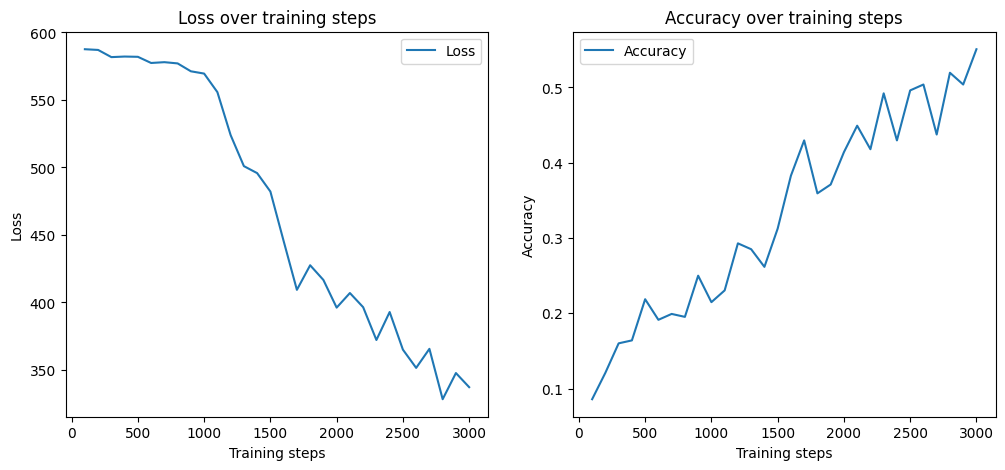

In [16]:
# Print the graphs of accuracy and loss versus step
# If everything is done correctly, the accuracy should increase and the losses should decrease

import matplotlib.pyplot as plt

# Display the graph of the loss function
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(display_step, training_steps + 1, display_step), loss_history, label='Loss')
plt.title('Loss over training steps')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.legend()

# Display the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history, label='Accuracy')
plt.title('Accuracy over training steps')
plt.xlabel('Training steps')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
# Calculate the accuracy of the trained neural network
def evaluate_model(neural_net, test_data):
    avg_accuracy = 0
    num_batches = 0

    for batch_x, batch_y in test_data:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        avg_accuracy += acc
        num_batches += 1

    avg_accuracy /= num_batches
    return avg_accuracy

# Testing the model on test data

In [19]:
# Test the trained neural network on 10 images. From the test set, take 5
# random images and feed them to the neural network.
# Print the image and write the neural network's response next to it.
# Conclude whether your neural network is wrong and if so, how often?

# Select 10 random images from the test dataset
random_indices = random.sample(range(len(x_test)), 10)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]


# Transforming images into a form suitable for a neural network
random_images_reshaped = random_images.reshape(-1, 28*28).astype('float32')

# Passing images to the neural network to get predictions
predictions = neural_net(random_images_reshaped)
predicted_labels = tf.argmax(predictions, axis=1)


# Conclusion about the accuracy of the model on random images
correct_predictions = tf.reduce_sum(tf.cast(predicted_labels == random_labels, tf.float32)).numpy()
total_predictions = len(random_labels)
accuracy = correct_predictions / total_predictions

print(f"Correct predictions: {correct_predictions}/{total_predictions}")
print(f"Accuracy on random samples: {accuracy:.4f}")

Correct predictions: 6.0/10
Accuracy on random samples: 0.6000
